In [ ]:
## Import Required Libraries
import os
import openslide
from openslide import open_slide

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob

from sklearn.model_selection import train_test_split

from PIL import Image

In [2]:
# Open with OPENSLIDE to get the full package to handle TIFF / Pyramidal format of filetype
slide = open_slide('images/wsi_ovary.svs')

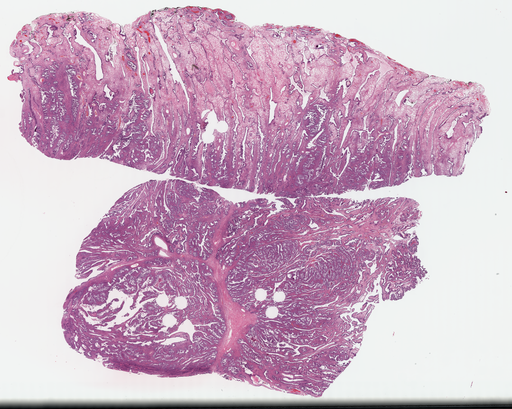

In [ ]:
# preview slide:
thumb = slide.get_thumbnail((512,512))
thumb

## IMPORT created tiles from slide using HistoClean module

In [4]:
# Path to folder
tile_folder = './images/tiled_images/wsi_ovary'

# Get all image paths (supports png/jpg/jpeg)
image_paths = sorted(glob.glob(os.path.join(tile_folder, '*.png')))  # or '*.jpg'

# Load images
tiles = []
for path in image_paths:
    img = Image.open(path).convert('RGB')  # Convert to 3 channels
    img = img.resize((512, 512))  # optional, if size is inconsistent
    tiles.append(np.array(img))

# Stack into array: shape (N, 512, 512, 3)
X = np.stack(tiles)

X = X.astype(np.float32) / 255.0

In [5]:
print("Shape of X:", X.shape)  # (num_tiles, 512, 512, 3)
print("Type of X:", X.dtype)  # Should be float32

Shape of X: (1306, 512, 512, 3)
Type of X: float32


In [8]:
# 80% train, 20% test
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Type of X_train:", X_train.dtype)  # Should be float32
print("Type of X_test:", X_test.dtype)  # Should be float32

Train shape: (1044, 512, 512, 3)
Test shape: (262, 512, 512, 3)
Type of X_train: float32
Type of X_test: float32


# Build and train the autoencoder

In [9]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

input_shape = (512, 512, 3)

In [ ]:
# --- Encoder ---
inputs = layers.Input(shape=input_shape)

x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x) 
x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x) 
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x) 

# Flatten spatial grid into a sequence: (batch, 32*32, 256)
x = layers.Reshape((32 * 32, 256))(x)

# Apply Conv1D across the sequence (optional kernel size = 1 or 3)
x = layers.Conv1D(1, kernel_size=1, activation='linear')(x)  # (batch, 1024, 1)

# Reshape to (32, 32)
latent = layers.Reshape((32, 32))(x)

2025-07-09 13:01:15.030011: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-07-09 13:01:15.030519: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-09 13:01:15.030528: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-07-09 13:01:15.030864: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-09 13:01:15.030920: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
# --- Decoder ---
# Add channel dimension back → (32, 32, 1)
x = Lambda(lambda x: K.expand_dims(x, axis=-1))(latent)

# Restore to 256 filters
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)

x = layers.Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)

# Final Output
outputs = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

In [12]:
autoencoder = models.Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 512, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1024, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1024, 1)        │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 32, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 128)  │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 512, 512, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 512, 512, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,369,476 (5.22 MB)

 Trainable params: 1,369,476 (5.22 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
autoencoder.fit(X_train, X_train, epochs=100, batch_size=8, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/100


2025-07-09 13:01:33.409023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


131/131 ━━━━━━━━━━━━━━━━━━━━ 45s 322ms/step - loss: 0.6480 - val_loss: 0.5752
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 290ms/step - loss: 0.5702 - val_loss: 0.5684
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 39s 293ms/step - loss: 0.5687 - val_loss: 0.5673
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 288ms/step - loss: 0.5669 - val_loss: 0.5674
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 290ms/step - loss: 0.5659 - val_loss: 0.5667
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 290ms/step - loss: 0.5654 - val_loss: 0.5667
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 291ms/step - loss: 0.5622 - val_loss: 0.5656
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 289ms/step - loss: 0.5666 - val_loss: 0.5665
Epoch 9/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 289ms/step - loss: 0.5645 - val_loss: 0.5657
Epoch 10/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 289ms/step - loss: 0.5618 - val_loss: 0.5653
Epoch 11/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 289ms/step - loss: 0.5615 - val_loss: 0.5652
Epoch 12/100
131/131

## Visualise the reconstructions side by side 

In [14]:
def show_reconstructions(model, X_data, n=5):
    """
    Show 'n' original and reconstructed images side-by-side.
    
    Parameters:
        model: trained autoencoder
        X_data: input data, shape (N, 512, 512, 3)
        n: number of images to display
    """
    decoded_imgs = model.predict(X_data[:n])

    plt.figure(figsize=(2 * n, 4))
    for i in range(n):
        # Original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_data[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstructed image
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title("Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


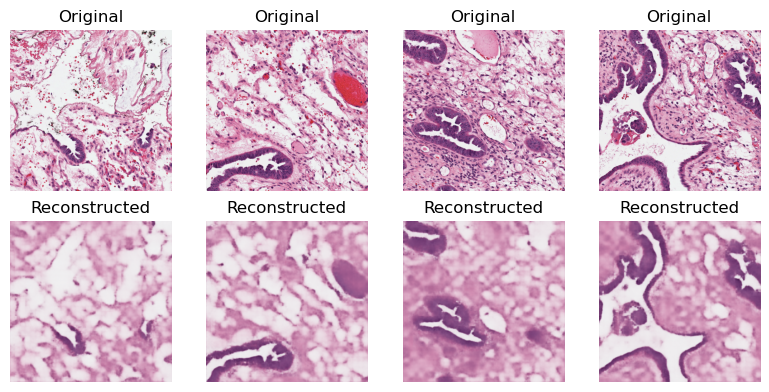

In [15]:
show_reconstructions(autoencoder, X, n=4)

## Save images to disk for size comparison. 

In [16]:
from tensorflow.keras.models import Model

# Suppose this is your encoder model:
encoder = Model(inputs=autoencoder.input, outputs=latent)

# Select an image
sample = X[1:2]  # shape (1, H, W, C)

# Get latent vector
compressed = encoder.predict(sample) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


In [17]:
sample.shape

(1, 512, 512, 3)

In [18]:
compressed.shape

(1, 32, 32)

In [19]:
np.save('compressed_sample.npy', compressed)

In [20]:
compressed.tofile('compressed_sample.bin')

In [21]:
# Assuming input image is scaled 0-1 and needs converting back to 0–255
img = (sample[0] * 255).astype(np.uint8)

# Save as PNG
Image.fromarray(img).save("original_image.png")

In [22]:
# copy of above make compressed to img ??
comp = (compressed[0] * 255).astype(np.uint8)

# Save as PNG
Image.fromarray(comp).save("compressed_image.png")

In [23]:
decoded = autoencoder.predict(X[1:2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


In [24]:
decoded.shape

(1, 512, 512, 3)

In [25]:
# output image is scaled 0-1 and needs converting back to 0–255
decoded_img = (decoded[0] * 255).astype(np.uint8)

# Save as PNG
Image.fromarray(decoded_img).save("reconstructed_image.png")

In [26]:
import os

original_size = os.path.getsize("original_image.png")
compressed_image_size = os.path.getsize("compressed_image.png")
compressed_size = os.path.getsize("compressed_sample.npy")
compressed_bin = os.path.getsize("compressed_sample.bin")
reconstructed_size = os.path.getsize("reconstructed_image.png")

print(f"Original image size: {original_size / 1024:.2f} KB")
print(f"Compressed image size: {compressed_image_size / 1024:.2f} KB")
print(f"Compressed latent size npy: {compressed_size / 1024:.2f} KB")
print(f"Compressed latent size bin: {compressed_bin / 1024:.2f} KB")
print(f"Reconstructed image size: {reconstructed_size / 1024:.2f} KB")

Original image size: 534.43 KB
Compressed image size: 1.10 KB
Compressed latent size npy: 4.12 KB
Compressed latent size bin: 4.00 KB
Reconstructed image size: 300.49 KB


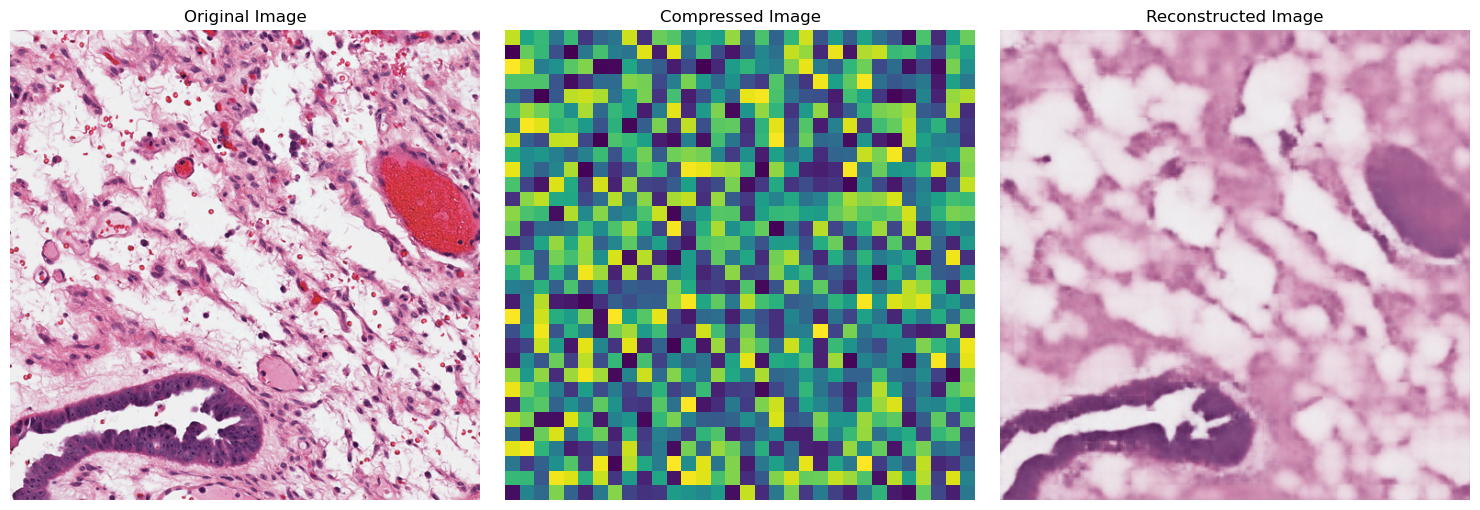

In [27]:
# Load the images
original = Image.open("original_image.png")
compressed = Image.open("compressed_image.png")
reconstructed = Image.open("reconstructed_image.png")

# Get file sizes in KB
# original_size = os.path.getsize("original_image.png") / 1024
# compressed_size = os.path.getsize("compressed_image.png") / 1024
# reconstructed_size = os.path.getsize("reconstructed_image.png") / 1024

# Create side-by-side display
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title(f"Original Image") #\n{original_size:.2f} KB
plt.axis("off")

# Compressed image
plt.subplot(1, 3, 2)
plt.imshow(compressed)
plt.title(f"Compressed Image") #\n{compressed_size:.2f} KB")
plt.axis("off")

# Reconstructed
plt.subplot(1, 3, 3)
plt.imshow(reconstructed)
plt.title(f"Reconstructed Image") #\n{reconstructed_size:.2f} KB")
plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()

## Extract latent vectors from new WSI_heart files using autoencoder to predict

In [28]:
# Path to folder
tile_folder = './images/tiled_images/wsi_heart'

# Get all image paths (supports png/jpg/jpeg)
image_paths = sorted(glob.glob(os.path.join(tile_folder, '*.png')))  # or '*.jpg'

# Load images
tiles = []
for path in image_paths:
    img = Image.open(path).convert('RGB')  # Convert to 3 channels
    img = img.resize((512, 512))  # optional, if size is inconsistent
    tiles.append(np.array(img))

# Stack into array: shape (N, 512, 512, 3)
Y = np.stack(tiles)

Y = Y.astype(np.float32) / 255.0

In [29]:
print("Shape of Y:", Y.shape)  # (num_tiles, 512, 512, 3)
print("Type of Y:", Y.dtype)  # Should be float32

Shape of Y: (115, 512, 512, 3)
Type of Y: float32


In [30]:
encoder = models.Model(inputs, latent)
latent_vectors = encoder.predict(Y)  # Shape: (N, 8, 8)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/stepWARNING:tensorflow:5 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x35669dda0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


In [31]:
latent_flat = latent_vectors.reshape(latent_vectors.shape[0], -1)  # (N, features)

In [32]:
latent_flat.shape

(115, 1024)

# Try to calculate the loss between original vs reconstructed image.

In [33]:
# Binary Crossentropy (BCE) is a loss function that measures the difference between two probability distributions — in our case, the original and reconstructed images interpreted as probabilities per pixel.
from tensorflow.keras.losses import BinaryCrossentropy

# Reconstruct the tiles
reconstructed = autoencoder.predict(Y)

# Define the BCE loss object
bce = BinaryCrossentropy()

# Compute per-image loss
per_image_loss = [bce(Y[i], reconstructed[i]).numpy() for i in range(len(Y))]

# Average loss across all tiles
average_loss = np.mean(per_image_loss)

print(f"BCE Loss for each image: {per_image_loss}\n")
print(f"Average Reconstruction Loss (BCE): {average_loss:.5f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step
BCE Loss for each image: [0.35340983, 0.42454904, 0.5501864, 0.57952195, 0.5882989, 0.589731, 0.59273034, 0.5935638, 0.582916, 0.52108735, 0.35414654, 0.51421857, 0.44383222, 0.55207866, 0.5764775, 0.5869334, 0.5680489, 0.59676135, 0.6002402, 0.5976759, 0.58096004, 0.38487995, 0.5145, 0.5674819, 0.52261883, 0.35604614, 0.54929996, 0.5715947, 0.576488, 0.5911562, 0.59657776, 0.6001797, 0.6006627, 0.59318936, 0.5298639, 0.56133235, 0.5730908, 0.56899524, 0.5188477, 0.5229961, 0.5736426, 0.58577335, 0.59568906, 0.5996292, 0.6007266, 0.5973935, 0.38546994, 0.5565818, 0.5516951, 0.5810003, 0.583216, 0.5633323, 0.5272841, 0.5541482, 0.59512365, 0.5979131, 0.5996679, 0.59608287, 0.38633463, 0.54535824, 0.44769704, 0.52788025, 0.39037496, 0.5734855, 0.5530246, 0.57974267, 0.5863318, 0.57410395, 0.55188715, 0.59849775, 0.5987192, 0.5947064, 0.36778015, 0.53180313, 0.5393412, 0.57830256, 0.5740494, 0.57688844, 0.548748, 0.43321276, 0.3640157, 0.4662678, 0.5

In [34]:
# This is the most common for pixel-wise comparison.
# Calculate per-tile MSE
mse_losses = np.mean((Y - reconstructed) ** 2, axis=(1, 2, 3))  # shape: (N,)

# Calculate overall average MSE - LOWER IS BETTER
average_mse = np.mean(mse_losses)

print(f"MSE Loss for each image: {mse_losses}\n")
print(f"Average Reconstruction Loss (MSE): {average_mse:.5f}")

MSE Loss for each image: [0.00239092 0.00465763 0.00793002 0.0089638  0.00911563 0.00888252
 0.00986192 0.00892199 0.00765403 0.00486548 0.00346641 0.0064056
 0.00452399 0.0076595  0.00918584 0.00901413 0.00914404 0.00946087
 0.00986264 0.01004248 0.00833727 0.00321354 0.00583639 0.0081932
 0.00659516 0.00319453 0.00782865 0.01005397 0.00932999 0.0095382
 0.00932713 0.01015927 0.00982146 0.00884196 0.00691968 0.00783704
 0.00938362 0.00868244 0.00669068 0.00795676 0.01158857 0.01014744
 0.01075051 0.01041072 0.01141039 0.00997296 0.00345744 0.00841924
 0.00843063 0.00919332 0.0095168  0.00873539 0.00618697 0.01051686
 0.01107252 0.01037585 0.01101618 0.00986255 0.00369203 0.00757279
 0.00380833 0.00487728 0.00287596 0.00828743 0.00823761 0.00922171
 0.00949482 0.0089992  0.00701209 0.01031089 0.01156977 0.01066136
 0.00317378 0.00762797 0.00818573 0.00802503 0.00901138 0.00778334
 0.00780457 0.00517914 0.00268641 0.00661933 0.00963399 0.0064814
 0.00832437 0.00769642 0.0078552  0.00687

In [35]:
# Calculate Structural Similarity Index (SSIM)
ssim_val = tf.image.ssim(Y, reconstructed, max_val=1.0)

# Calculate overall average SSIM - HIGHER IS BETTER
average_ssim = np.mean(ssim_val)

print(f"SSIM Loss for each image: {ssim_val}\n")
print(f"Average SSIM Loss: {average_ssim:.5f}")

SSIM Loss for each image: [0.63760257 0.4621048  0.28856978 0.26850036 0.2760858  0.28461277
 0.2756393  0.29314518 0.3057463  0.38292563 0.58532304 0.32445702
 0.44978085 0.29252127 0.26150504 0.27448833 0.32411456 0.29778257
 0.29323754 0.2980907  0.2952963  0.568837   0.35262156 0.2719334
 0.32823443 0.6103946  0.27507755 0.26245695 0.281988   0.26985
 0.28814387 0.288056   0.27079102 0.29369116 0.30980226 0.27316013
 0.25437257 0.24187316 0.30220088 0.33181056 0.22674571 0.2554
 0.24879175 0.23856413 0.25636673 0.25101525 0.5611886  0.276849
 0.30293676 0.24096112 0.22583811 0.24663647 0.29181802 0.2738517
 0.23278852 0.2531276  0.24317609 0.2595888  0.56115395 0.31850782
 0.5015389  0.36805746 0.59168434 0.24686445 0.31290177 0.24386716
 0.22060508 0.2401272  0.264359   0.24253064 0.24910636 0.26551804
 0.59677124 0.31206107 0.29545638 0.25982246 0.24374108 0.26032335
 0.28232685 0.50188065 0.60317916 0.47803673 0.26493868 0.303715
 0.2907658  0.35411608 0.27095333 0.2990243  0.39

In [36]:
# Calculate Peak Signal-to-noise Ratio (PSNR)
psnr_val = tf.image.psnr(Y, reconstructed, max_val=1.0)

# Calculate overall average PSNR - Up to 50. HIGHER IS BETTER
average_psnr = np.mean(psnr_val)

print(f"PSNR Loss for each image: {psnr_val}\n")
print(f"Average PSNR Loss: {average_psnr:.5f}")

PSNR Loss for each image: [26.21434  23.318344 21.007257 20.475079 20.402134 20.514637 20.060385
 20.495382 21.161098 23.128742 24.601196 21.934402 23.444784 21.157995
 20.368813 20.450762 20.38862  20.240688 20.06007  19.981588 20.789759
 24.93016  22.338558 20.865463 21.807745 24.95593  21.063131 19.976624
 20.301188 20.205336 20.302517 19.931376 20.078238 20.534515 21.599136
 21.058481 20.276297 20.613577 21.745298 20.992636 19.359703 19.936434
 19.685709 19.825193 19.426992 20.011755 24.612448 20.747269 20.741398
 20.365276 20.21509  20.587173 22.085218 19.781141 19.557535 19.839762
 19.579689 20.060106 24.32734  21.207441 24.19265  23.118221 25.412178
 20.815804 20.841986 20.351887 20.22513  20.457962 21.541521 19.867039
 19.366753 19.721872 24.984228 21.175909 20.869425 20.955536 20.452082
 21.088343 21.076508 22.857424 25.708273 21.791857 20.161938 21.88331
 20.796484 21.137112 21.048426 21.629896 22.095474 23.290554 21.682528
 20.769348 21.170004 24.376156 23.191414 22.580996 2

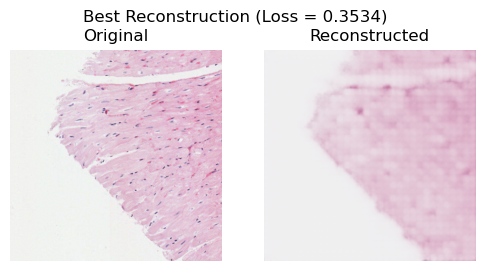

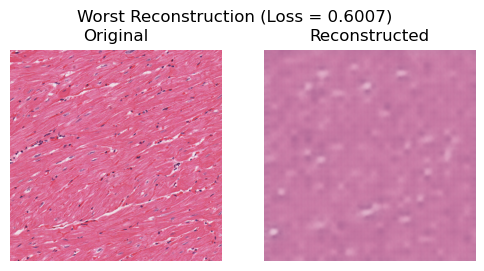

In [ ]:
# Show best and worst ... REALLY INTERESTING! 

# Get indices of best and worst
best_idx = np.argmin(per_image_loss)
worst_idx = np.argmax(per_image_loss)

def show_tile_comparison(index, title):
    plt.figure(figsize=(6, 3))
    plt.suptitle(title)

    # Original
    plt.subplot(1, 2, 1)
    plt.imshow(Y[index])
    plt.title("Original")
    plt.axis("off")

    # Reconstruction
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed[index])
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

show_tile_comparison(best_idx, f"Best Reconstruction (Loss = {per_image_loss[best_idx]:.4f})")
show_tile_comparison(worst_idx, f"Worst Reconstruction (Loss = {per_image_loss[worst_idx]:.4f})")

In [38]:
original_image = Y[0]
print("ORIGINAL IMAGE - Shape: ", original_image.shape, ", Size: ", original_image.size)

latent_vector = latent_vectors[0]
print("LATENT VECTOR - Shape: ", latent_vector.shape, ", Size: ", latent_vector.size)

# Percentage compression achieved.
compression_percentages = []

for original_image, latent_vector in zip(Y, latent_vectors):
    original_size = original_image.size
    latent_size = latent_vector.size
    # Calc percent for each tile
    percent = (1 - (latent_size / original_size)) * 100
    compression_percentages.append(percent)

average_compression = np.mean(compression_percentages)
print("Average compression across all tiles: {:.2f}%".format(average_compression))

ORIGINAL IMAGE - Shape:  (512, 512, 3) , Size:  786432
LATENT VECTOR - Shape:  (32, 32) , Size:  1024
Average compression across all tiles: 99.87%
